In [1]:
import faiss
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import random
from glob import glob

In [2]:
with open("./data/landscapes_descriptors.pkl", "rb") as f:
    files = pickle.load(f)

for file in files:
    file["path"] = str(Path("../landscapes/train/") / file["class"] / f"{file['filename']}.jpg")

print(f"Loaded {len(files)} descriptors arrays")
print(f"Total number of SIFT descriptors: {sum([len(f['descriptors']['sift']) for f in files])}")
print(f"Total number of ORB descriptors: {sum([len(f['descriptors']['orb']) for f in files])}")

Loaded 540 descriptors arrays
Total number of SIFT descriptors: 54101
Total number of ORB descriptors: 53975


In [3]:
descriptors_sift = np.concatenate([f['descriptors']["sift"] for f in files if f['descriptors'] is not None], axis=0).astype(np.float32)
descriptors_orb = np.concatenate([f['descriptors']["orb"] for f in files if f['descriptors'] is not None], axis=0).astype(np.float32)

In [4]:
kmeans_sift = faiss.Kmeans(descriptors_sift.shape[1],
                      200,
                      niter=300,
                      nredo=1,
                      verbose=True,
                      gpu=True)
kmeans_sift.train(descriptors_sift)
print(kmeans_sift.centroids.shape)

Sampling a subset of 51200 / 54101 for training
Clustering 51200 points in 128D to 200 clusters, redo 1 times, 300 iterations
  Preprocessing in 0.01 s
  Iteration 299 (2.98 s, search 2.07 s): objective=3.13096e+09 imbalance=1.182 nsplit=0       
(200, 128)


In [5]:
kmeans_orb = faiss.Kmeans(descriptors_orb.shape[1],
                      90,
                      niter=300,
                      nredo=1,
                      verbose=True,
                      gpu=True)
kmeans_orb.train(descriptors_orb)
print(kmeans_orb.centroids.shape)

Sampling a subset of 23040 / 53975 for training
Clustering 23040 points in 32D to 90 clusters, redo 1 times, 300 iterations
  Preprocessing in 0.00 s
  Iteration 299 (0.61 s, search 0.35 s): objective=2.30241e+09 imbalance=1.035 nsplit=0       
(90, 32)


In [6]:
for file in files:
    D, I = kmeans_sift.index.search(file['descriptors']['sift'].astype(np.float32), 1)
    word_idx = I.flatten();
    bow = np.bincount(word_idx.ravel(), minlength=kmeans_sift.centroids.shape[0])
    # normalized = bow / np.linalg.norm(bow)
    file['bow_sift'] = bow

In [7]:
for file in files:
    D, I = kmeans_orb.index.search(file['descriptors']['orb'].astype(np.float32), 1)
    word_idx = I.flatten();
    bow = np.bincount(word_idx.ravel(), minlength=kmeans_orb.centroids.shape[0])
    # normalized = bow / np.linalg.norm(bow)
    file['bow_orb'] = bow

In [8]:
for file in files:
    file['bow'] = np.concatenate([file['bow_sift'], file['bow_orb']], axis=0)

In [9]:
df = np.zeros(kmeans_sift.centroids.shape[0] + kmeans_orb.centroids.shape[0], dtype=np.float32)
for file in files:
    for i in range(len(file['bow'])):
        df[i] += file['bow'][i] > 0

df = df / len(files)

for file in files:
    term_frequencies = file['bow'] / np.linalg.norm(file['bow'])
    file['tfidf'] = term_frequencies * np.log(1 / df)

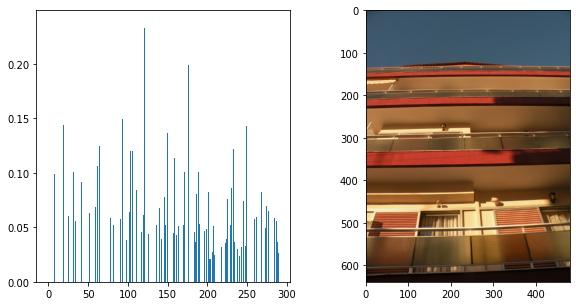

In [10]:
random_file = random.choice(files)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax2.imshow(cv2.cvtColor(cv2.imread(random_file["path"]), cv2.COLOR_BGR2RGB))
ax1.bar(range(len(random_file['tfidf'])), random_file['tfidf'])
plt.show()

In [11]:
test_files = glob("../buildings/test/*.jpg")

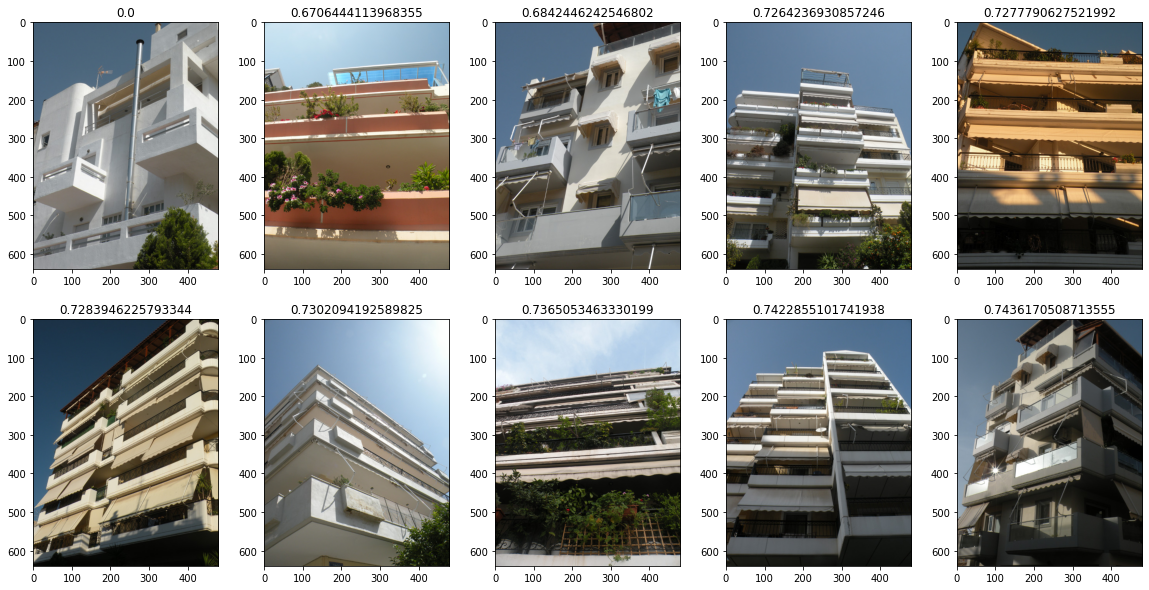

In [12]:
import scipy.spatial.distance as metrics
distances = []
random_file = random.choice(files)

for file in files:
    distance = metrics.correlation(random_file['tfidf'], file['tfidf'])
    distances.append({
        'path': file["path"],
        'distance': distance
    })

distances = sorted(distances, key=lambda x: x['distance'], reverse=False)

fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(5):
    axs[0][i].imshow(cv2.cvtColor(cv2.imread(distances[i]['path']), cv2.COLOR_BGR2RGB))
    axs[0][i].set_title(distances[i]['distance'])
    axs[1][i].imshow(cv2.cvtColor(cv2.imread(distances[5+i]['path']), cv2.COLOR_BGR2RGB))
    axs[1][i].set_title(distances[5+i]['distance'])


In [13]:
from img2vec import img2vec
y_true = []
y_pred = []

for file_path in test_files:
    building = file_path.split("/")[-1].split("_")[0]
    y_true.append(building)

    test_img = cv2.imread(file_path)
    test_img_descriptors = img2vec(test_img)

    D_sift, I_sift = kmeans_sift.index.search(test_img_descriptors["sift"].astype(np.float32), 1)
    D_orb, I_orb = kmeans_orb.index.search(test_img_descriptors["orb"].astype(np.float32), 1)

    word_idx_sift = I_sift.flatten();
    word_idx_orb = I_orb.flatten();
    bow_sift = np.bincount(word_idx_sift.ravel(), minlength=kmeans_sift.centroids.shape[0])
    bow_orb = np.bincount(word_idx_orb.ravel(), minlength=kmeans_orb.centroids.shape[0])
    bow = np.concatenate([bow_sift, bow_orb], axis=0)

    term_frequencies = bow / np.linalg.norm(bow)
    tfidf = term_frequencies * np.log(1 / df)

    distances = []
    for tfile in files:
        distance = metrics.braycurtis(tfile['tfidf'], tfidf)
        distances.append({
            'path': tfile["path"],
            'building': tfile["filename"].split("_")[0],
            'distance': distance
        })

    srt = sorted(distances, key=lambda x: x['distance'], reverse=False)
    top3 = srt[0]
    predicted_building = top3['building']
    y_pred.append(predicted_building)

    if building == predicted_building:
        print(f"Correctly predicted {building}")
    else:
        print(f"Wrongly predicted {building} as {predicted_building}")


Correctly predicted building14
Correctly predicted building48
Correctly predicted building17
Wrongly predicted building15 as building53
Correctly predicted building28
Correctly predicted building09
Wrongly predicted building45 as building04
Wrongly predicted building59 as building58
Wrongly predicted building10 as building24
Correctly predicted building01
Wrongly predicted building24 as building08
Wrongly predicted building19 as building03
Wrongly predicted building16 as building18
Correctly predicted building11
Correctly predicted building15
Wrongly predicted building24 as building50
Correctly predicted building48
Correctly predicted building44
Correctly predicted building19
Correctly predicted building24
Wrongly predicted building53 as building19
Correctly predicted building09
Correctly predicted building55
Wrongly predicted building43 as building47
Correctly predicted building15
Wrongly predicted building07 as building48
Correctly predicted building27
Wrongly predicted building08 as

<AxesSubplot: >

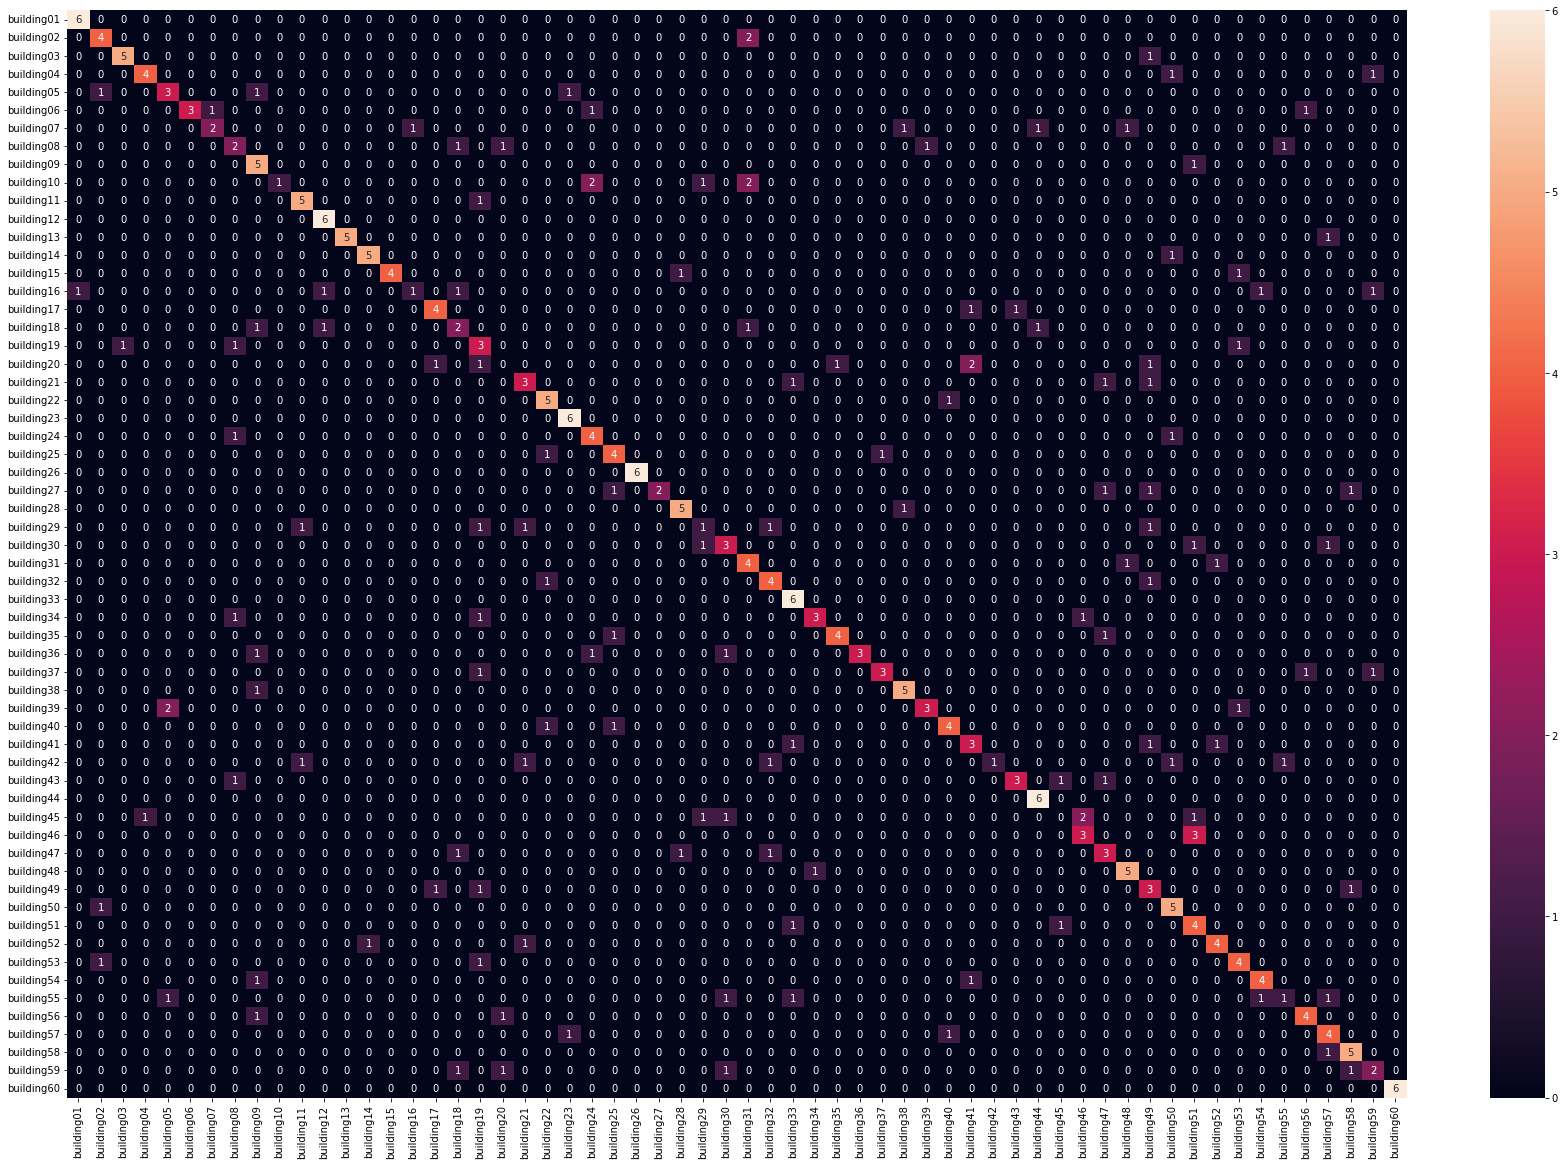

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(y_true)],
                  columns = [i for i in np.unique(y_true)])
plt.figure(figsize = (30,20))
sn.heatmap(df_cm, annot=True)

In [17]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
print(accuracy_score(y_true, y_pred))
print(f1_score(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

0.6055555555555555
0.58987690414161
              precision    recall  f1-score   support

  building01       0.86      1.00      0.92         6
  building02       0.57      0.67      0.62         6
  building03       0.83      0.83      0.83         6
  building04       0.80      0.67      0.73         6
  building05       0.50      0.50      0.50         6
  building06       1.00      0.50      0.67         6
  building07       0.67      0.33      0.44         6
  building08       0.33      0.33      0.33         6
  building09       0.45      0.83      0.59         6
  building10       1.00      0.17      0.29         6
  building11       0.71      0.83      0.77         6
  building12       0.75      1.00      0.86         6
  building13       1.00      0.83      0.91         6
  building14       0.83      0.83      0.83         6
  building15       1.00      0.67      0.80         6
  building16       0.50      0.17      0.25         6
  building17       0.67      0.67      0.67  

In [21]:
all_test_files = glob("../landscapes/test/*/*.jpeg")
random.shuffle(all_test_files)
print(f"Testing {len(all_test_files)} images")
classes = ["Coast", "Desert", "Forest", "Mountain", "Glacier"]

Testing 500 images


In [22]:
from img2vec import img2vec

y_true = []
y_pred = []

for idx, test_file in enumerate(all_test_files):
    test_img = cv2.imread(test_file)
    test_img_descriptors = img2vec(test_img)
    test_img_class = Path(test_file).parent.name
    y_true.append(classes.index(test_img_class))

    D_sift, I_sift = kmeans_sift.index.search(test_img_descriptors["sift"].astype(np.float32), 1)
    D_orb, I_orb = kmeans_orb.index.search(test_img_descriptors["orb"].astype(np.float32), 1)

    word_idx_sift = I_sift.flatten();
    word_idx_orb = I_orb.flatten();
    bow_sift = np.bincount(word_idx_sift.ravel(), minlength=kmeans_sift.centroids.shape[0])
    bow_orb = np.bincount(word_idx_orb.ravel(), minlength=kmeans_orb.centroids.shape[0])
    bow = np.concatenate([bow_sift, bow_orb], axis=0)

    term_frequencies = bow / np.linalg.norm(bow)
    tfidf = term_frequencies * np.log(1 / df)

    distances = []
    for file in files:
        distance = metrics.correlation(tfidf, file['tfidf'])
        distances.append({
            'path': file["path"],
            'class': file["class"],
            'distance': distance
        })
    
    top10 = sorted(distances, key=lambda x: x['distance'], reverse=False)[:3]
    top10_classes = [x["class"] for x in top10]
    top10_class = max(set(top10_classes), key=top10_classes.count)
    y_pred.append(classes.index(top10_class))

    if top10_class != test_img_class:
        print(f"FAIL ({idx}/{len(all_test_files)}) Predicted {top10_class} but was {test_img_class}")
    else:
        print(f"PASS ({idx}/{len(all_test_files)}) Predicted {top10_class} and was {test_img_class}")

ValueError: 'buildings' is not in list